# The Zangellini Similarity

In [1]:
# Imports
from tqdm import tqdm_notebook
import numpy as np
from matplotlib import pyplot as plt
from quantum_systems import OneDimensionalHarmonicOscillator
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccsd import TDCCSD
from coupled_cluster.ccd import TDCCD
from coupled_cluster.integrators import GaussIntegrator
from tdhf import HartreeFock
from coupled_cluster.mix import DIIS

In [2]:
# Major Lazer
class LaserPulse:
    def __init__(self, laser_frequency=2, laser_strength=1):
        self.laser_frequency = laser_frequency
        self.laser_strength = laser_strength

    def __call__(self, t):
        return self.laser_strength * np.sin(self.laser_frequency * t)

In [3]:
# The Zanghellini system
n = 2
l = 12
length = 10
num_grid_points = 400
omega = 0.25
laser_frequency = 8 * omega
laser_strength = 1

zanghellini = OneDimensionalHarmonicOscillator(
    n, l, length, num_grid_points, omega=omega
)
zanghellini.setup_system()
major_laser = LaserField(
    LaserPulse(
        laser_frequency=laser_frequency, laser_strength=laser_strength
    )
)

zanghellini_2 = OneDimensionalHarmonicOscillator(
    n, l, length, num_grid_points, omega=omega
)

zanghellini_2.setup_system()
lazer_blazer = LaserField(
    LaserPulse(
        laser_frequency=laser_frequency, laser_strength=laser_strength
    )
)

zanghellini.set_time_evolution_operator(major_laser)

zanghellini_2.set_time_evolution_operator(lazer_blazer)

In [4]:
# zanghellini.change_to_hf_basis(tolerance=1e-6)
# zanghellini_2.change_to_hf_basis(tolerance=1e-6)

In [5]:
tdccsd_zanghellini = TDCCSD(zanghellini, 
                            np=np, 
                            verbose=True, 
                            mixer=DIIS, 
                            integrator=GaussIntegrator(np=np, eps=1e-6))
tdccsd_zanghellini.compute_ground_state(t_kwargs=dict(num_vecs=5), l_kwargs=dict(num_vecs=5))
print(f"HF->CCSD ground state energy: {tdccsd_zanghellini.compute_ground_state_energy().real:8.7}")

Iteration: 0	Residuals (t): [0.6377530375749664, 1.8018602754817126]
Iteration: 1	Residuals (t): [0.5552773037552684, 2.211131939131309]
Iteration: 2	Residuals (t): [0.4866685413877025, 1.083078642157898]
Iteration: 3	Residuals (t): [0.14926183434725282, 0.9374044494514234]
Iteration: 4	Residuals (t): [0.18319813898650528, 0.7355915308145832]
Iteration: 5	Residuals (t): [0.1796757147131127, 0.4218903688975708]
Iteration: 6	Residuals (t): [0.23831559109598674, 1.8973523311397587]
Iteration: 7	Residuals (t): [0.607698730938964, 0.27965243840594695]
Iteration: 8	Residuals (t): [0.08711444740187088, 0.44736034851846945]
Iteration: 9	Residuals (t): [0.013398644853547125, 0.4745812698675544]
Iteration: 10	Residuals (t): [0.01205770364780719, 0.6049816714732057]
Iteration: 11	Residuals (t): [0.006877532946734245, 0.6041405285948265]
Iteration: 12	Residuals (t): [0.04031577762555096, 0.794677857814415]
Iteration: 13	Residuals (t): [0.0820371370087056, 0.3886475494873267]
Iteration: 14	Residual

Iteration: 54	Residuals (l): [5.9725042115469554e-05, 0.0007462262490307458]
Iteration: 55	Residuals (l): [9.302313485302445e-05, 0.0014586478934942458]
Iteration: 56	Residuals (l): [9.553152270209697e-05, 0.0012023544637779027]
Iteration: 57	Residuals (l): [4.080644188506472e-05, 0.00025266067508797384]
Iteration: 58	Residuals (l): [3.734959634729142e-05, 6.618399651462913e-05]
HF->CCSD ground state energy: 0.8259119


In [6]:
tdccd_zanghellini = TDCCD(zanghellini_2, 
                            np=np, 
                            verbose=True, 
                            mixer=DIIS, 
                            integrator=GaussIntegrator(np=np, eps=1e-6))
tdccd_zanghellini.compute_ground_state(t_kwargs=dict(num_vecs=5), l_kwargs=dict(num_vecs=5))
print(f"HF->CCD ground state energy: {tdccd_zanghellini.compute_ground_state_energy().real:8.7}")

Iteration: 0	Residuals (t): [1.5567526042750413]
Iteration: 1	Residuals (t): [1.7995013554836767]
Iteration: 2	Residuals (t): [0.2896877663894019]
Iteration: 3	Residuals (t): [0.16433955298392158]
Iteration: 4	Residuals (t): [0.03875782993253763]
Iteration: 5	Residuals (t): [0.05381168631659864]
Iteration: 6	Residuals (t): [0.006115594961166342]
Iteration: 7	Residuals (t): [0.002879013286459596]
Iteration: 8	Residuals (t): [0.0008023979170390685]
Iteration: 9	Residuals (t): [0.0002159439039076084]
Iteration: 10	Residuals (t): [1.1677991545603558e-05]
Iteration: 0	Residuals (l): [1.8370848790073666]
Iteration: 1	Residuals (l): [2.530897813819092]
Iteration: 2	Residuals (l): [0.12932817191429075]
Iteration: 3	Residuals (l): [0.025589709996398157]
Iteration: 4	Residuals (l): [0.01361892708343618]
Iteration: 5	Residuals (l): [0.004275570647229726]
Iteration: 6	Residuals (l): [0.001266300410508762]
Iteration: 7	Residuals (l): [0.0001666559968377967]
Iteration: 8	Residuals (l): [5.2604351807

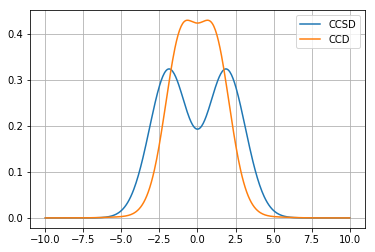

In [7]:
rho = tdccsd_zanghellini.compute_ground_state_particle_density()
rho_2 = tdccd_zanghellini.compute_ground_state_particle_density()
plt.plot(zanghellini.grid, rho.real, label="CCSD")
plt.plot(zanghellini_2.grid, rho_2.real, label="CCD")
plt.legend()
plt.grid()
plt.show()

In [8]:
tdccsd_zanghellini.set_initial_conditions()
tdccd_zanghellini.set_initial_conditions()

In [9]:
num_time_steps = 1301
time_points = np.linspace(0, 13, num_time_steps)
psi_overlap_tdccsd = np.zeros(num_time_steps)
td_energies_tdccsd = np.zeros(num_time_steps)
psi_overlap_tdccd = np.zeros(num_time_steps)
td_energies_tdccd = np.zeros(num_time_steps)

psi_overlap_tdccsd[0] = tdccsd_zanghellini.compute_time_dependent_overlap().real
td_energies_tdccsd[0] = tdccsd_zanghellini.compute_energy().real
psi_overlap_tdccd[0] = tdccd_zanghellini.compute_time_dependent_overlap().real
td_energies_tdccd[0] = tdccd_zanghellini.compute_energy().real

In [10]:
for i, amp in tqdm_notebook(enumerate(tdccsd_zanghellini.solve(time_points)), total=num_time_steps-1):
    psi_overlap_tdccsd[i + 1] = tdccsd_zanghellini.compute_time_dependent_overlap().real
    td_energies_tdccsd[i + 1] = tdccsd_zanghellini.compute_energy().real

for i, amp in tqdm_notebook(enumerate(tdccd_zanghellini.solve(time_points)), total=num_time_steps-1):
    psi_overlap_tdccd[i + 1] = tdccd_zanghellini.compute_time_dependent_overlap().real
    td_energies_tdccd[i + 1] = tdccd_zanghellini.compute_energy().real

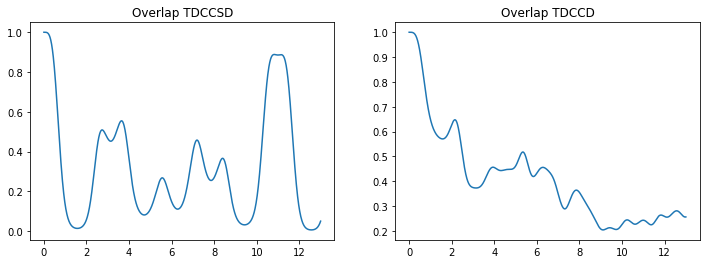

In [11]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_points, psi_overlap_tdccsd)
ax[0].set_title("Overlap TDCCSD")
ax[1].plot(time_points, psi_overlap_tdccd)
ax[1].set_title("Overlap TDCCD")
plt.show()

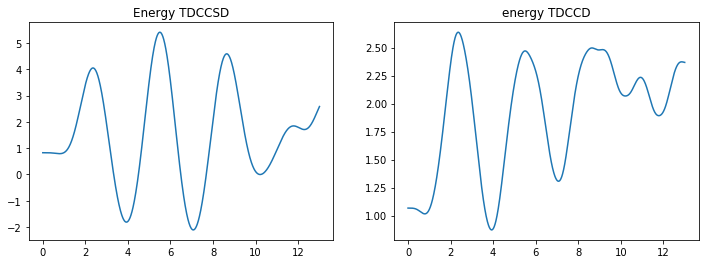

In [12]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_points, td_energies_tdccsd)
ax[0].set_title("Energy TDCCSD")
ax[1].plot(time_points, td_energies_tdccd)
ax[1].set_title("energy TDCCD")
plt.show()